In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import FinanceDataReader as fdr


import pandas as pd
df = pd.read_csv('usd_kospi.csv')
df = df.dropna()
# df에 NaN 값 확인
print("NaN values in the dataset:")
print(df.isna().sum())

NaN values in the dataset:
Date                         0
usd_krw_usd_krw_Open         0
usd_krw_usd_krw_High         0
usd_krw_usd_krw_Low          0
usd_krw_usd_krw_Close        0
usd_krw_usd_krw_Adj Close    0
usd_krw_usd_krw_Volume       0
Open                         0
High                         0
Low                          0
Close                        0
Volume                       0
Change                       0
UpDown                       0
Comp                         0
Amount                       0
MarCap                       0
dtype: int64


In [2]:
# NaN 값 처리 - 여기서는 제거하는 것으로 가정
df = df.dropna()

# 2개의 컬럼을 Feature로 사용
cols = ['usd_krw_usd_krw_Close', 'Close']
data = df[cols].values
df.set_index("Date", inplace=True)
df

,usd_krw_usd_krw_Open,usd_krw_usd_krw_High,usd_krw_usd_krw_Low,usd_krw_usd_krw_Close,usd_krw_usd_krw_Adj Close,usd_krw_usd_krw_Volume,Open,High,Low,Close,Volume,Change,UpDown,Comp,Amount,MarCap
Date,,,,,,,,,,,,,,,,
2003-12-01,1197.300049,1203.500000,1195.000000,1198.400024,1198.400024,0.0,796.36,811.49,790.80,807.39,584981695,0.0141,1,11.21,2550377558805,349500523487910
2003-12-02,1198.099976,1198.500000,1186.199951,1195.000000,1195.000000,0.0,813.49,813.95,806.30,807.78,531989534,0.0005,1,0.39,2437988447945,349565163750845
2003-12-03,1195.000000,1198.400024,1192.500000,1192.500000,1192.500000,0.0,807.17,816.02,801.08,808.34,440581943,0.0007,1,0.56,2428345205640,349870920905375
2003-12-04,1192.599976,1197.900024,1174.800049,1190.099976,1190.099976,0.0,805.10,809.68,800.31,805.13,493935192,-0.0040,2,-3.21,2390462801590,348454820024130
2003-12-05,1189.400024,1193.800049,1178.599976,1184.699951,1184.699951,0.0,802.71,802.86,789.41,789.41,426505593,-0.0195,2,-15.72,2144828459030,341762940055240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30,1370.550049,1380.930054,1369.739990,1370.550049,1370.550049,0.0,2666.63,2666.63,2635.44,2635.44,372741998,-0.0156,2,-41.86,11132062547655,2150594911810807
2024-05-31,1375.619995,1387.489990,1375.359985,1375.619995,1375.619995,0.0,2657.87,2664.48,2635.77,2636.52,613717789,0.0004,1,1.08,16353906904146,2151017465412147
2024-06-03,1382.099976,1382.109985,1369.969971,1382.099976,1382.099976,0.0,2657.81,2690.73,2657.81,2682.52,782329142,0.0174,1,46.00,13995552060921,2188764087625754


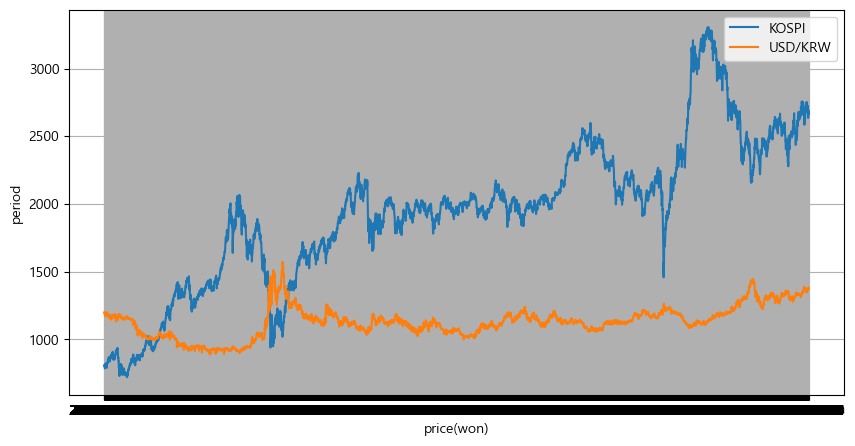

In [3]:
plt.figure(figsize = (10,5))
plt.xlabel('price(won)')
plt.ylabel('period')

plt.grid()

plt.plot(df['Close'], label='KOSPI')
plt.plot(df['usd_krw_usd_krw_Close'], label='USD/KRW')
plt.legend()
plt.show()

In [4]:
# 데이터 스케일링 (0과 1 사이 값으로 스케일링)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [5]:
# 시계열 데이터를 윈도우로 나누기
sequence_length = 30  # 30일 데이터 기준으로
forecast_days = 5  # 앞으로 5일을 예측
X = []
y = []
for i in range(len(data) - sequence_length - forecast_days + 1):
    X.append(data[i:i + sequence_length])
    y.append(data[i + sequence_length:i + sequence_length + forecast_days])

X = np.array(X)
y = np.array(y)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 예측 대상인 forecast_days를 사용하여 reshape
y_train = y_train.reshape(-1, forecast_days * len(cols))
y_val = y_val.reshape(-1, forecast_days * len(cols))

In [7]:
# GRU 모델 구축
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(GRU(32, activation='relu'))
model.add(Dense(forecast_days * len(cols)))  # 출력 레이어를 forecast_days * feature 수로 설정
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint('checkpoint.keras',
                             monitor='val_loss',  # 모델을 저장할 때 기준이 되는 값 (검증 손실)
                             save_best_only=True,  # 가장 좋은(낮은 손실) 모델만 저장
                             save_weights_only=False,  # 모델 아키텍처와 가중치 모두 저장
                             mode='min',  # 손실을 최소화하는 방향으로 모델을 저장
                             verbose=1  # 저장할 때 메시지 출력
                             )

# 모델 훈련
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint])
# 베스트 weights 로드
model.load_weights('checkpoint.keras')

Epoch 1/50


C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1670 - mse: 0.1670
Epoch 1: val_loss improved from inf to 0.02504, saving model to checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1652 - mse: 0.1652 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0145 - mse: 0.0145
Epoch 2: val_loss improved from 0.02504 to 0.00208, saving model to checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - mse: 0.0015
Epoch 3: val_loss improved from 0.00208 to 0.00100, saving model to checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 4/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2801e-04 - mse: 9.2801e-04
Epoch 4: val_loss improved from 0.00100 to 0.00064, saving model to checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s

In [8]:
# 모델을 사용하여 예측
predictions = model.predict(X_val)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [9]:
# 예측 성능 평가
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.00037075659361917527
Mean Absolute Error: 0.012540298989322626


In [10]:
# 모델을 사용하여 예측, 배치를 위해서 1차원을 추가하여 input 데이터 맞춰야 합니다.
predictions = model.predict(np.array([data[-sequence_length:]]))

reshaped_predictions = predictions[0].reshape(forecast_days, len(cols))  # (1, forecast_days * len(cols)) => (forecast_days, len(cols)) 차원 변경 
original_predictions = scaler.inverse_transform(reshaped_predictions)

predict_df = pd.DataFrame(original_predictions, columns=cols)

# 원천 데이터의 날짜 마지막일자 이후로 5일자 날짜를 index로 구성
last_date = pd.to_datetime(df.index[-1])  # data.index의 마지막 날짜를 datetime으로 변환
date_range = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')  # 마지막 날짜 다음날부터 5일치 날짜 생성
predict_df.index = date_range  # 예측 결과의 index를 생성한 날짜 범위로 설정

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [11]:
predict_df

,usd_krw_usd_krw_Close,Close
2024-06-06,1371.613281,2670.465576
2024-06-07,1372.447266,2675.143555
2024-06-08,1371.249634,2677.527344
2024-06-09,1371.253174,2685.610352
2024-06-10,1365.692993,2691.954102


In [12]:
predict_df.to_csv('predict_df_GRU.csv', index=False)

In [13]:

# 저장할 디렉토리 경로와 파일 이름을 포함한 전체 경로 지정
directory_path = r'C:\Users\USER\Desktop\JH\DA-35\proj\CSV'
file_name = 'predict_df_GRU.csv'
file_path = f'{directory_path}\\{file_name}'

# DataFrame을 지정한 경로에 CSV 파일로 저장
predict_df.to_csv(file_path, index=False)

print(f'CSV 파일이 {file_path}에 저장되었습니다.')

OSError: Cannot save file into a non-existent directory: 'C:\Users\USER\Desktop\JH\DA-35\proj\CSV'

In [14]:
print(date_range)

DatetimeIndex(['2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10'],
              dtype='datetime64[ns]', freq='D')


In [15]:
predict_df.index

DatetimeIndex(['2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10'],
              dtype='datetime64[ns]', freq='D')

In [16]:
#달러환율 6/5일이후
df_usd_krw= fdr.DataReader('USD/KRW', '2024-06-06')
df_usd_krw= pd.DataFrame(df_usd_krw)
df_usd_krw.index = df_usd_krw.index.strftime('%m-%d')

In [17]:
#코스피 6/5일이후
df_Kospi2 = fdr.DataReader('KS11', '2024-06-06')
df_Kospi2 = pd.DataFrame(df_Kospi2)
df_Kospi2.index = df_Kospi2.index.strftime('%m-%d')

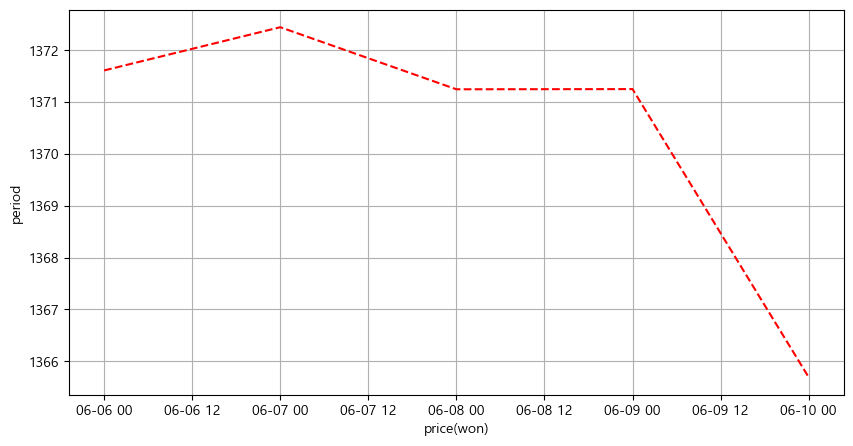

In [18]:
plt.figure(figsize = (10,5))
plt.xlabel('price(won)')
plt.ylabel('period')
plt.grid()

plt.plot(predict_df['usd_krw_usd_krw_Close'], label='pred_Price', color='r',linestyle='--')

plt.show()

In [23]:
#비교 데이터프레임 만들기 
data = [
    [predict_df['usd_krw_usd_krw_Close'].iloc[0], df_usd_krw['Close'].iloc[0],predict_df['Close'].iloc[0],df_Kospi2['Close'].iloc[0]],
    [predict_df['usd_krw_usd_krw_Close'].iloc[1], df_usd_krw['Close'].iloc[1],predict_df['Close'].iloc[1],df_Kospi2['Close'].iloc[1]],
    [predict_df['usd_krw_usd_krw_Close'].iloc[2], df_usd_krw['Close'].iloc[2],'공휴일','공휴일'],
    [predict_df['usd_krw_usd_krw_Close'].iloc[3], df_usd_krw['Close'].iloc[3],'공휴일','공휴일'],
    [predict_df['usd_krw_usd_krw_Close'].iloc[4], df_usd_krw['Close'].iloc[4],predict_df['Close'].iloc[4],df_Kospi2['Close'].iloc[4]]
]
 
results_GRU = pd.DataFrame(
    data=data,
    index=['6/6', '6/7', '6/8', '6/9', '6/10'],
    columns=['USD/KRW예측값', 'USD/KRW실제값','KOSPI예측값','KOSPI실제값']
)

## GRU_달러환율 및 코스피 예측값과 실제값 비교

In [24]:
results_GRU

,USD/KRW예측값,USD/KRW실제값,KOSPI예측값,KOSPI실제값
6/6,1371.613281,1368.739990,2670.465576,2722.67
6/7,1372.447266,1365.250000,2675.143555,2701.17
6/8,1371.249634,1379.050049,공휴일,공휴일
6/9,1371.253174,1373.959961,공휴일,공휴일
6/10,1365.692993,1377.359985,2691.954102,2754.89


In [25]:
#성능평가 데이터 프레임
data = [mse,mae]
res = pd.DataFrame(data=data, index=['MSE','MAE'],columns=['GRU 성능평가'])
res

,GRU 성능평가
MSE,0.000371
MAE,0.012540


In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 예측값과 실제값
predictions = [1371.613281, 1372.447266, 1371.249634, 1371.253174, 1365.692993]
actuals = [1368.739990, 1365.250000, 1379.050049, 1373.959961, 1377.359985]

# MSE와 MAE 계산
mse_usd_krw = mean_squared_error(actuals, predictions)
mae_usd_krw = mean_absolute_error(actuals, predictions)

mse, mae

# 결과 출력
print("USD/KRW 예측값과 실제값:")
print("Mean Squared Error (MSE):", mse_usd_krw)
print("Mean Absolute Error (MAE):", mae_usd_krw)


USD/KRW 예측값과 실제값:
Mean Squared Error (MSE): 52.8696622818192
Mean Absolute Error (MAE): 6.44895019999999
